In [1]:
# set the current working directory
import os
os.chdir("../")

In [79]:
import warnings
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils

from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

---

# Data Exploration of Divvy Trip Data

[Divvy](https://divvybikes.com/) is a real company in Chicago that rents bikes, e-bikes, e-scooters, like Bolt in Oslo.

**Brief Dataset Description:**
* Data source: https://divvybikes.com/system-data?utm_source=chatgpt.com
* The data is available from 2020.04 till 2025.12.
* The data includes the following features:
    * (categorical) vechical type: {classic bike, electric bike}
    * (datetime) Trip start day and time
    * (datetime) Trip end day and time
    * (str) Trip start station
    * (str) Trip end station
    * (float) Trip start latitude, longitude
    * (float) Trip end latitude, longitude
    * (categorical) member or non-member


**Motivation behind choosing this dataset:** 
* ABAX deals with spatial-locational data, thus I thought this dataset is a good fit for this technical assessment assignment. 
* This analysis is done from scratch for this assignment.

**Remarks:**
* Author: Daesoo Lee
* LinkedIn: https://www.linkedin.com/in/daesoo-lee/
* For all texts and the chain of thoughts & reasoning for this analysis, no AI tool is used. I have put much time and effort.

---

# Exploration Plans

1. Additional data that can be added
    * traveling distance = (end location - start location)
    * traveling duration = (end time - start time)
    * speed = (end location - start location) / (end time - start time)
    * weekday vs weekend
    * ~~weather (I won't use it as the project scopes really expands.. but it's probably a good variable to be used in practice)~~

2. Analysis: Basic
    * mean, std, correlation matrix, histrogram, unique values, etc
    * Find outliers, any missing values; clean the dataset
        * Q. any non-sense riding duration? 
        * Q. any non-sense distance?
        * Q. any non-sense speed (i.e., end time - starting time)?

3. Analysis: In-depth
    3.1. w.r.t membership
    3.2. w.r.t vehicle type
    3.3. w.r.t day type (weekday vs weekend)



4. Analysis: conditional distributions
    * hour <-> location (station name)
        * Q. which locations are popular at certian hours?
    * hour <-> count(rides) w.r.t membership
    
    * vehicle type <-> location
    * vehicle type <-> membership
    * location <-> membership


3. Analysis: Map of conditional distributions
    * Q. what's the density distribution of the rides on a map throughout all hours? 
    * Q. the spatial density distribution of rides at different hours of a day
    * Q. the spatial density distribution of rides with respect to a vehicle type
    * Q. the spatial density distribution of rides with respect to membership
    * Q. the spatial density distribution of rides with respect to {weekday vs weekend}

4. Analysis: Rest of conditional distributions
    * Q. datetime <-> vehicle type
    * ~~(done in the above analysis) datetime <-> location~~
    * Q. datetime <-> membership
    * ~~(done in the above analysis) vehicle type <-> location~~
    * Q. vehicle type <-> membership
    * ~~(done in the above analysis) location <-> membership~~

5. Analysis: Trend over years
    * Q. Any trend over years (i.e., same months over years)?
    * Q. Any difference between different months? (e.g., summer vs winter)

6. Analysis: Clustering (to find multi-feature-depedent patterns)
    * PCA
    * ML clustering (K-means, DBSCAN)

---

In [3]:
# load data
df = pd.read_csv("data/202508-divvy-tripdata.csv")

df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"] = pd.to_datetime(df["ended_at"])

# sample 1000 samples for faster visualizations
df = df.sample(n=10_000, random_state=42).reset_index(drop=True)

## 1. Additional data

In [4]:
df["traveling_distance"] = utils.haversine_km(df["end_lat"], df["end_lng"], df["start_lat"], df["start_lng"])  # [km]
df["traveling_duration"] = (df["ended_at"] - df["started_at"]).abs().dt.total_seconds() / 3600  # [h]
df["traveling_speed"] = df["traveling_distance"] / (df["traveling_duration"])  # [km/h]
df["day_type"] = np.where(df["started_at"].dt.dayofweek < 5, "weekday", "weekend")

## 2. Analysis: Basic

For the initial analysis, I pick the data from August 2025. The patterns probably differ depending on different months of a year but we'll investigate that in a later section. I suppose that the overall trend should remain similar.

Let's take a look at basic stats of the dataset.

In [5]:
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,traveling_distance,traveling_duration,traveling_speed,day_type
0,83B035E7C4C1A738,electric_bike,2025-08-19 21:46:03.113,2025-08-19 21:50:54.074,Wood St & Milwaukee Ave,CHI00329,Damen Ave & Thomas St (Augusta Blvd),CHI00296,41.907655,-87.672552,41.901315,-87.677409,casual,0.811516,0.080823,10.040722,weekday
1,25846140DEDFBABE,classic_bike,2025-08-14 18:26:13.634,2025-08-14 19:11:10.846,Lakefront Trail & Bryn Mawr Ave,CHI00298,DuSable Lake Shore Dr & North Blvd,CHI00525,41.984044,-87.652281,41.911722,-87.626804,member,8.313294,0.749226,11.095850,weekday
2,921F135D2F4D01D2,electric_bike,2025-08-25 14:58:01.616,2025-08-25 15:14:10.481,Lincoln Park Conservatory,CHI00626,Rush St & Cedar St,CHI00537,41.923931,-87.635825,41.902309,-87.627691,casual,2.496756,0.269129,9.277165,weekday
3,B23437223220E5B5,electric_bike,2025-08-07 19:17:26.204,2025-08-07 19:31:32.108,Clark St & Montrose Ave,CHI00562,Broadway & Oakdale Ave,CHI02073,41.961588,-87.666036,41.935586,-87.644047,member,3.415583,0.234973,14.536045,weekday
4,DE708BFDC4E9C396,classic_bike,2025-08-06 17:35:28.604,2025-08-06 17:47:24.432,Spaulding Ave & Armitage Ave,CHI00635,Western Ave & Winnebago Ave,CHI00282,41.917108,-87.710221,41.915520,-87.687022,member,1.927646,0.198841,9.694401,weekday


In [6]:
df.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,traveling_distance,traveling_duration,traveling_speed
count,10000,10000,10000.000000,10000.000000,9992.000000,9992.000000,9992.000000,10000.000000,9992.000000
mean,2025-08-16 11:53:15.558178560,2025-08-16 12:10:29.529286656,41.906069,-87.645785,41.906647,-87.646105,2.305895,0.287214,11.558804
min,2025-07-31 23:54:21.001000,2025-08-01 00:00:29.507000,41.670600,-87.824230,41.670600,-87.840000,0.000000,0.000097,0.000000
25%,2025-08-08 14:34:18.334000128,2025-08-08 14:51:39.358000128,41.883380,-87.659141,41.883984,-87.659570,0.937290,0.100259,7.300459
50%,2025-08-16 10:48:48.440999936,2025-08-16 11:12:09.881999872,41.900000,-87.641088,41.900219,-87.641190,1.719374,0.177608,10.972068
75%,2025-08-24 09:54:32.368999936,2025-08-24 10:27:27.664999936,41.930000,-87.629544,41.932225,-87.629912,3.045886,0.311883,14.569829
max,2025-08-31 23:18:01.576000,2025-08-31 23:55:19.309000,42.064854,-87.530844,42.070000,-87.530910,20.223362,24.999189,787.516882
std,NaN,NaN,0.040923,0.026060,0.041040,0.026188,2.066471,0.810465,18.005277


**Findings**
- This dataset contains all data points throughout the month, starting from 2025-07-31 23:54:21 till 2025-08-31 23:55.
- `traveling_distance` [km] has minimum of zero. This probably indicates that there are some people who unlocked and locked for some reason.
- `traveling_duration` [hour] has maximum of 25 hours which doesn't make sense. It's probably a case where somebody forgot to lock the bike.
- `traveling_speed` [km/h] has maximum of 787. This is probably some GPS sensor glitch.

In [7]:
# unique values of the categorical variables

print("Unique values of the categorical variables:", end="\n\n")
print("=================================================")
print("rideable_type:", df["rideable_type"].unique(), end="\n\n")
print("start_station_name:", df["start_station_name"].unique()[:10], end="\n\n")  # print the first 10 only
print("end_station_name:", df["end_station_name"].unique()[:10], end="\n\n")  # print the first 10 only
print("member_casual:", df["member_casual"].unique())
print("=================================================")

Unique values of the categorical variables:

rideable_type: ['electric_bike' 'classic_bike']

start_station_name: ['Wood St & Milwaukee Ave' 'Lakefront Trail & Bryn Mawr Ave'
 'Lincoln Park Conservatory' 'Clark St & Montrose Ave'
 'Spaulding Ave & Armitage Ave' 'Southport Ave & Belmont Ave'
 'DuSable Lake Shore Dr & North Blvd' 'Rush St & Superior St'
 'Wells St & Randolph St' 'Clinton St & Madison St']

end_station_name: ['Damen Ave & Thomas St (Augusta Blvd)'
 'DuSable Lake Shore Dr & North Blvd' 'Rush St & Cedar St'
 'Broadway & Oakdale Ave' 'Western Ave & Winnebago Ave'
 'Sheridan Rd & Irving Park Rd' nan 'Canal St & Madison St'
 'Orleans St & Merchandise Mart Plaza' 'Dearborn Pkwy & Delaware Pl']

member_casual: ['casual' 'member']


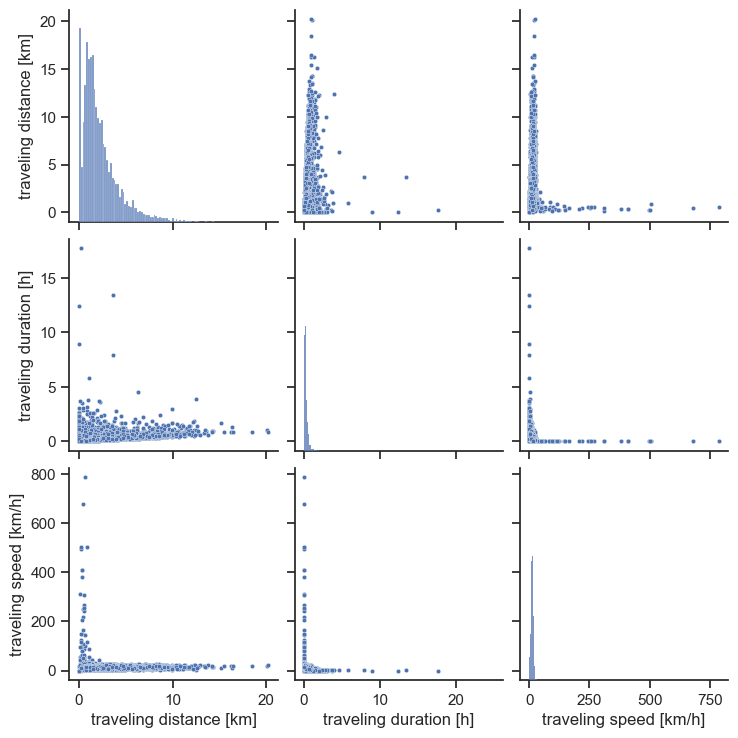

In [8]:
df_ = df[["rideable_type", "member_casual", 
          "traveling_distance", "traveling_duration", "traveling_speed"]]
df_.columns = ["rideable_type", "member_casual", 
               "traveling distance [km]", "traveling duration [h]", "traveling speed [km/h]"]
sns.set_theme(style="ticks")
sns.pairplot(df_, plot_kws={"s": 10})

**Findings**
- `traveling distance` and `traveling duration` have a log-normal distribution.
- Like the above findings, `traveling duration` and `traveling speed` have anomalies, which I'll remove.

### 2.1 Remove anomalies

Let's look at the histogram of `traveling_duration`.

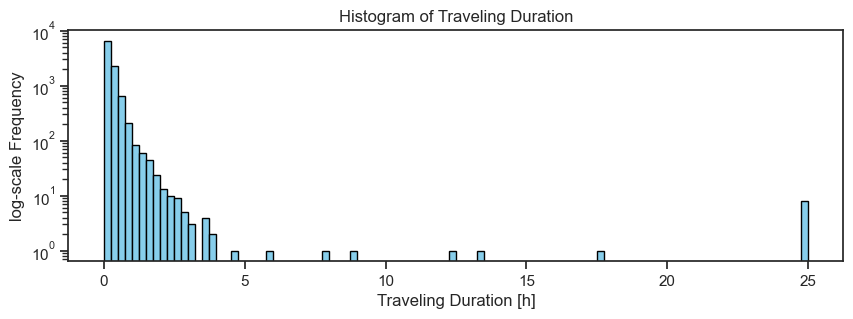

In [9]:
# plot traveling duration
plt.figure(figsize=(10, 3))
plt.hist(df["traveling_duration"], bins=100, color='skyblue', edgecolor='black', log=True)
plt.title("Histogram of Traveling Duration")
plt.xlabel("Traveling Duration [h]")
plt.ylabel("log-scale Frequency")
plt.show();

In [10]:
# remove samples below 1 minute above 5 hours
df = df[(df["traveling_duration"] >= (1/60)) & (df["traveling_duration"] <= 5)]

**Action**
* removed rows whose traveling duration is below 1 minute and above 5 hours.

Let's look at the histogram of `traveling_speed`.

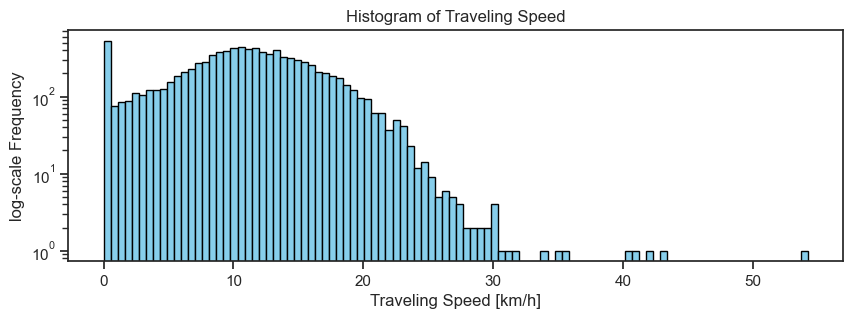

In [11]:
# plot traveling speed
plt.figure(figsize=(10, 3))
plt.hist(df["traveling_speed"], bins=100, color='skyblue', edgecolor='black', log=True)
plt.title("Histogram of Traveling Speed")
plt.xlabel("Traveling Speed [km/h]")
plt.ylabel("log-scale Frequency")
plt.show();

**Remarks**
- The maximum speed limit of the Divvy bikes is 32 km/h (to be exact 32,1869 km/h). 
- Thus, I can remove all samples whose traveling speed is above 32 km/h.

In [12]:
# remove samples whose traveling speed is above 32.1869 km/h
df = df[df["traveling_speed"] <= 32.1869]

**Action**
- remove all samples whose traveling speed is above 32 km/h.

Now let's take another look at the plot of the cleaned dataset.

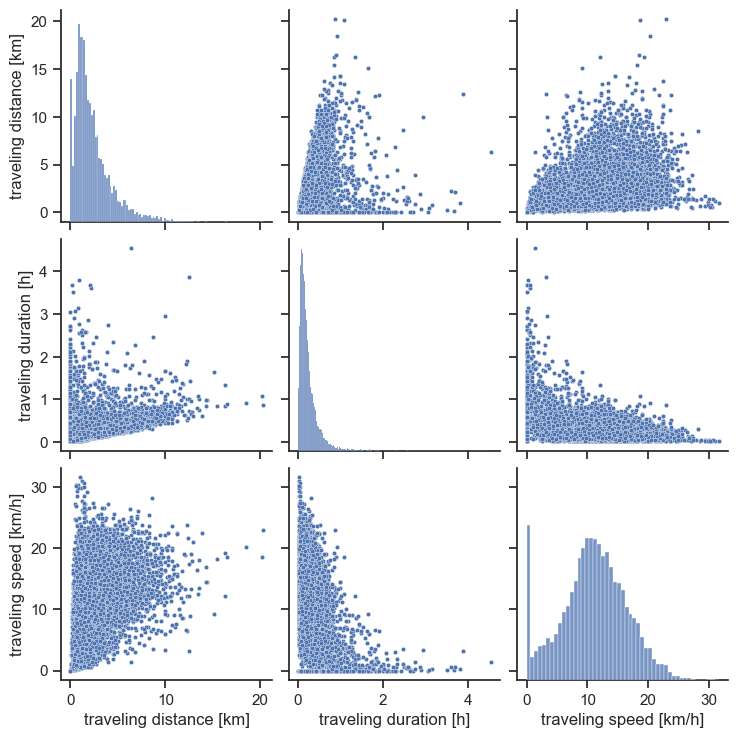

In [13]:
df_ = df[["rideable_type", "member_casual", 
          "traveling_distance", "traveling_duration", "traveling_speed"]]
df_.columns = ["rideable_type", "member_casual", 
               "traveling distance [km]", "traveling duration [h]", "traveling speed [km/h]"]
sns.set_theme(style="ticks")
sns.pairplot(df_, plot_kws={"s": 10})

**Findings**
- Now the dataset looks much cleaner.
- A positive correlation between `traveling_distance` and `traveling_duration`.
- There are traveling distances that are near zero despite the high traveling duration. This should indicate a "loop" traveller -- likely to be a lesiure user; very likely to be tourists.
- A positive correlation between `traveling_distance` and `traveling_speed`. For people who travel long distances, they tend to go on faster speed.
- Most people ride less than 10km and less than an hour per ride with average speed of around 12 km/h.

## 3. Analysis: In-Depth

### 3.1. with respect to membership

Let's take a closer look at the traveling duration because it seems that a lot of people seem to ride for a very-short period of time.

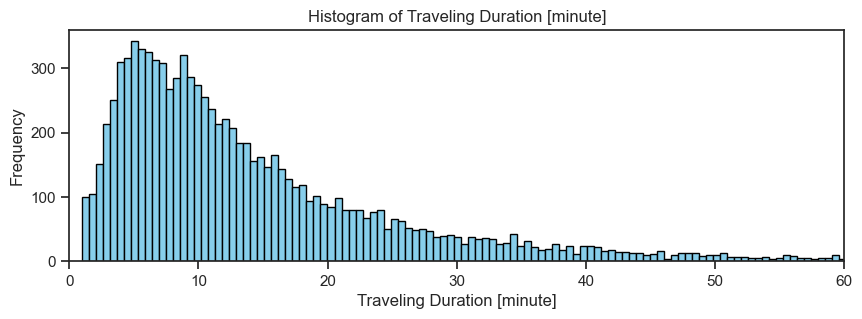

In [22]:
plt.figure(figsize=(10, 3))
plt.hist(df["traveling_duration"]* 60, bins=500, color='skyblue', edgecolor='black')
plt.xlabel("Traveling Duration [minute]")
plt.ylabel("Frequency")
plt.title("Histogram of Traveling Duration [minute]")
plt.xlim(0, 60)
plt.show()

**Reasoning**
* A lot of people ride less than 5 minutes. This probably correponds to these rides where people ride to get to the nearest bus stops / subway stations from where they are, and vice versa. I've seen many people doing this here in Norway.
* For non-members, there is a $1 fee for "unlocking", therefore these very-short durations are likely to be by members. 
* Let's see conditional probability distributions of traveling durations w.r.t membership.

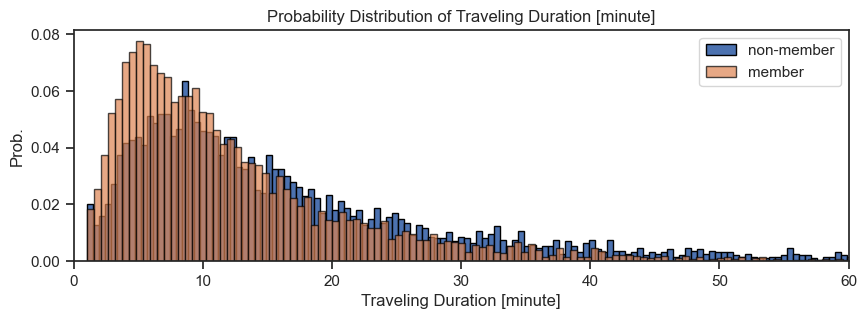

In [73]:
plt.figure(figsize=(10, 3))
plt.hist(df[df["member_casual"]=="casual"]["traveling_duration"]* 60, bins=500, edgecolor='black', density=True, label="non-member")
plt.hist(df[df["member_casual"]=="member"]["traveling_duration"]* 60, bins=500, edgecolor='black', alpha=0.7, density=True, label="member")
plt.xlabel("Traveling Duration [minute]")
plt.ylabel("Prob.")
plt.title("Probability Distribution of Traveling Duration [minute]")
plt.xlim(0, 60)
plt.legend(loc="upper right")
plt.show()

**Findings**
* As I suspected, non-members tend to ride longer durations than members due to the unlocking fee.

Let's do further analysis w.r.t the membership by plotting conditional distributions of the traveling duration and speed.

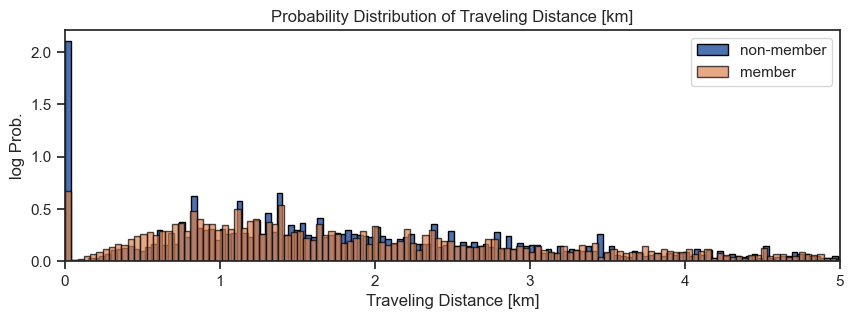

In [74]:
plt.figure(figsize=(10, 3))
plt.hist(df[df["member_casual"]=="casual"]["traveling_distance"], bins=500, edgecolor='black', density=True, label="non-member")
plt.hist(df[df["member_casual"]=="member"]["traveling_distance"], bins=500, edgecolor='black', alpha=0.7, density=True, label="member")
plt.xlabel("Traveling Distance [km]")
plt.ylabel("log Prob.")
plt.title("Probability Distribution of Traveling Distance [km]")
plt.xlim(0, 5)
plt.legend(loc="upper right")
plt.show()

**Findings**
* The non-members have a much-higher zero distance. This is probably contributed by first-time users who are confused at how to use it.
* Similarly mentioned before, non-members tend to avoid riding for very-short distances due to the unlocking fee. 

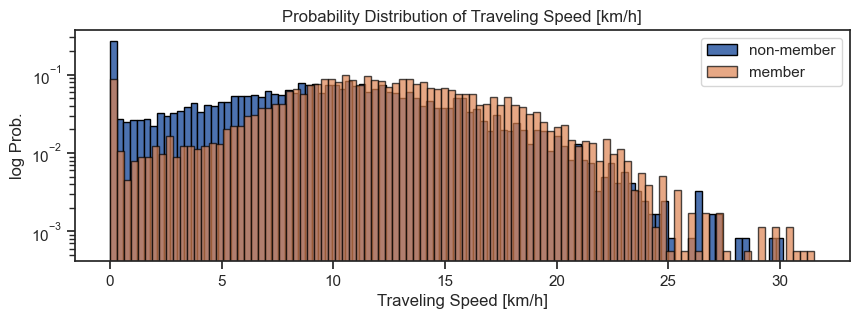

In [75]:
plt.figure(figsize=(10, 3))
plt.hist(df[df["member_casual"]=="casual"]["traveling_speed"], bins=100, edgecolor='black', density=True, label="non-member", log=True)
plt.hist(df[df["member_casual"]=="member"]["traveling_speed"], bins=100, edgecolor='black', alpha=0.7, density=True, label="member", log=True)
plt.xlabel("Traveling Speed [km/h]")
plt.ylabel("log Prob.")
plt.title("Probability Distribution of Traveling Speed [km/h]")
plt.legend(loc="upper right")
plt.show()

**Findings**
* Members tend to ride faster than non-members.
* Non-members are likely to ride it less often than members, therefore riding it more safely. 
* This is probably correlated to a number of accidents -- i.e., members tend to get into accidents more often since they're over-confident in riding. There can be some action taken to prevent that.

Let's look at the overall plot again but with respect to the membership.

/var/folders/6b/xq6p5wgd1yl1j44j7gncy_g80000gn/T/ipykernel_83259/2594244632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["member_casual"] = df_["member_casual"].apply(lambda x: "non-member" if x == "casual" else x)


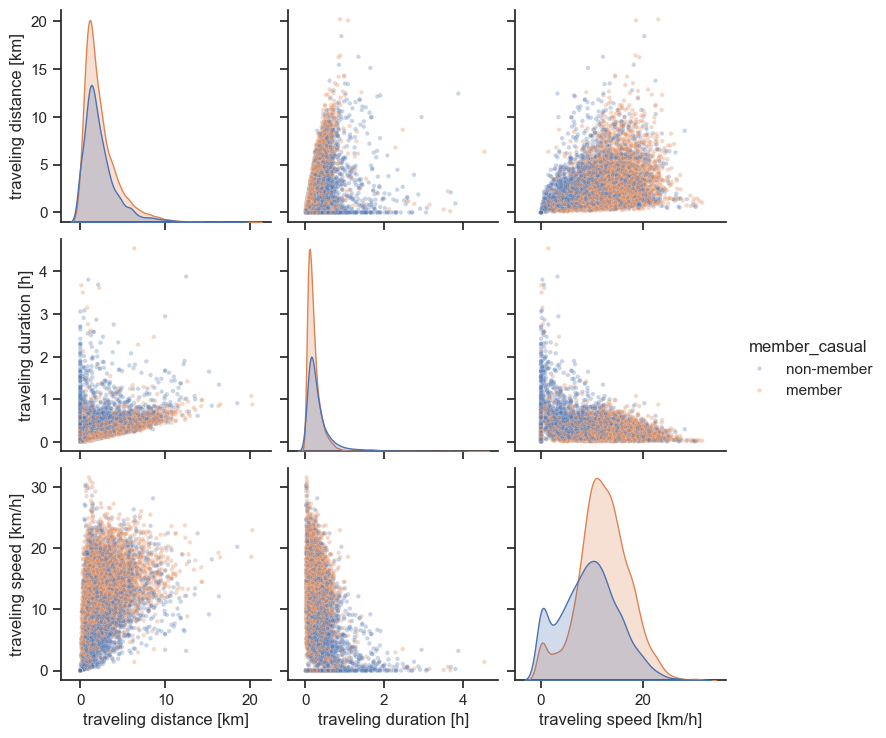

In [77]:
df_ = df[["rideable_type", "member_casual", 
          "traveling_distance", "traveling_duration", "traveling_speed"]]
df_["member_casual"] = df_["member_casual"].apply(lambda x: "non-member" if x == "casual" else x)
df_.columns = ["rideable_type", "member_casual", 
               "traveling distance [km]", "traveling duration [h]", "traveling speed [km/h]"]
sns.set_theme(style="ticks")
sns.pairplot(df_, plot_kws={"s": 10, "alpha": 0.3}, hue="member_casual");

**Findings**
* `traveling distance` vs `traveling duration` [1st row, 2nd column]: for the same duration, members tend to go further, equivalently ride faster. One noticeable pattern here is that almost only non-members have zero traveling distance (i.e., coming back to the pickup point) for long durations (longer than 30 min). Now I'm certain that they're using for leisure like tourists because tourists won't bother sign up for membership.
* [1st row, 3rd column] and [2nd row, 3rd column] simply suggest that members ride faster.

**Reasoning**
* Considering that a large portion of the non-members is tourists, the riding patterns throughout a day must be different! Let's plot and see.

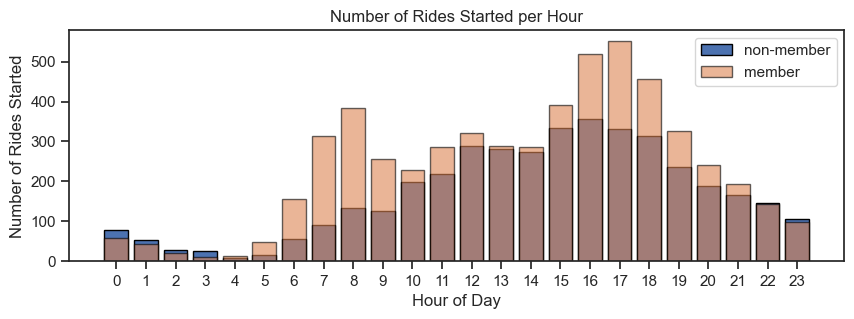

In [94]:
hour_counts_nonmember = df[df["member_casual"]=="casual"]["started_at"].dt.hour.value_counts().sort_index()
hour_counts_member = df[df["member_casual"]=="member"]["started_at"].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.bar(hour_counts_nonmember.index, hour_counts_nonmember.values, edgecolor="black", label="non-member")
plt.bar(hour_counts_member.index, hour_counts_member.values, edgecolor="black", label="member", alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides Started")
plt.title("Number of Rides Started per Hour")
plt.xticks(range(0,24))
plt.legend()
plt.show()

**Findings**
* Cool finding here. As suspected, there is a significant riding pattern difference between non-members and members throughout a day.
* members ridings hours peak at around commuting hours.
    * considering this, it's probably a good idea for the company to collect bikes and place many of them at around residental areas so that people ride them to go to work or nearest bus stops or subway stations.
* non-members riding hours are spread out across 7am til 2am, following a normal distribution.

### 3.2. with respect to vehicle type

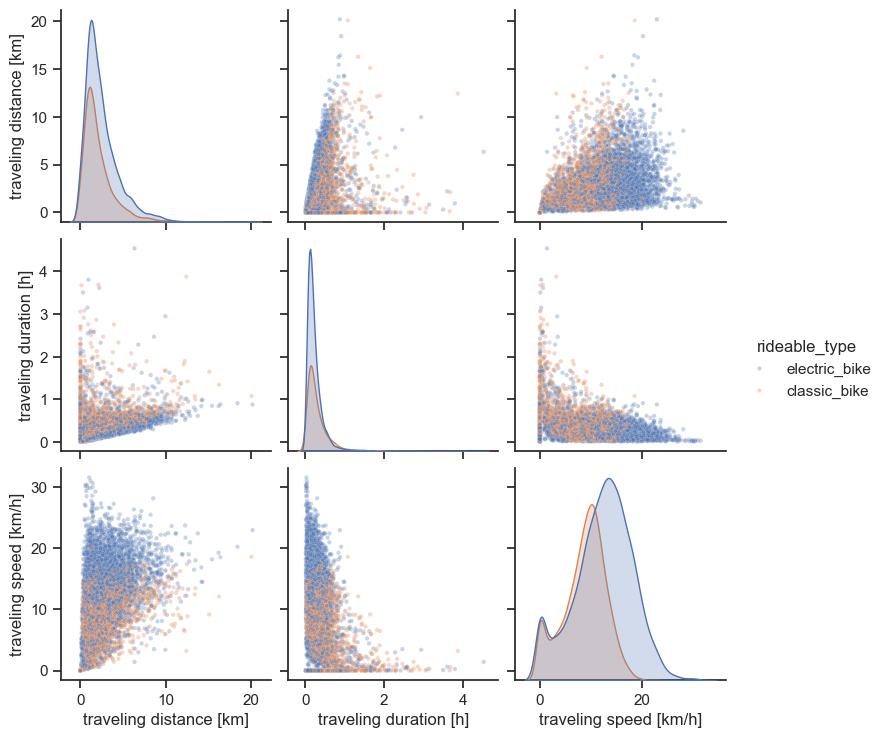

In [80]:
df_ = df[["rideable_type", "member_casual", 
          "traveling_distance", "traveling_duration", "traveling_speed"]]
df_["member_casual"] = df_["member_casual"].apply(lambda x: "non-member" if x == "casual" else x)
df_.columns = ["rideable_type", "member_casual", 
               "traveling distance [km]", "traveling duration [h]", "traveling speed [km/h]"]
sns.set_theme(style="ticks")
sns.pairplot(df_, plot_kws={"s": 10, "alpha": 0.3}, hue="rideable_type");

**Findings**
- Obvious findings here:
- More people take electric bikes than classic bikes although classic bikes are about twice cheaper.
- Electric bikes basically go further and faster.

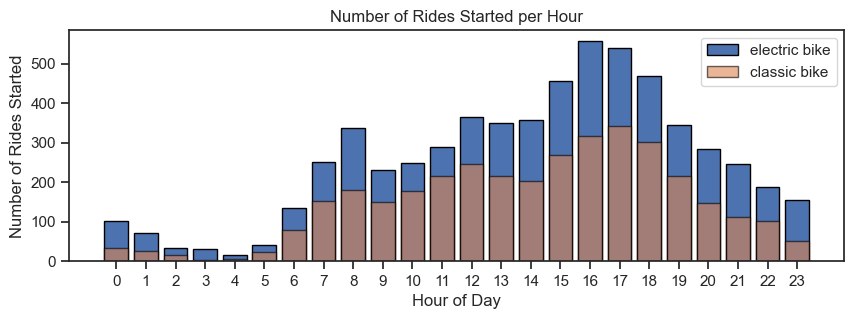

In [97]:
hour_counts_c1 = df[df["rideable_type"]=="electric_bike"]["started_at"].dt.hour.value_counts().sort_index()
hour_counts_c2 = df[df["rideable_type"]=="classic_bike"]["started_at"].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.bar(hour_counts_c1.index, hour_counts_c1.values, edgecolor="black", label="electric bike")
plt.bar(hour_counts_c2.index, hour_counts_c2.values, edgecolor="black", label="classic bike", alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides Started")
plt.title("Number of Rides Started per Hour")
plt.xticks(range(0,24))
plt.legend()
plt.show()

**Findings**
- No noticeable pattern difference. 
- More people take electric bikes than classic bikes for convience.

### 3.3. with respect to day type

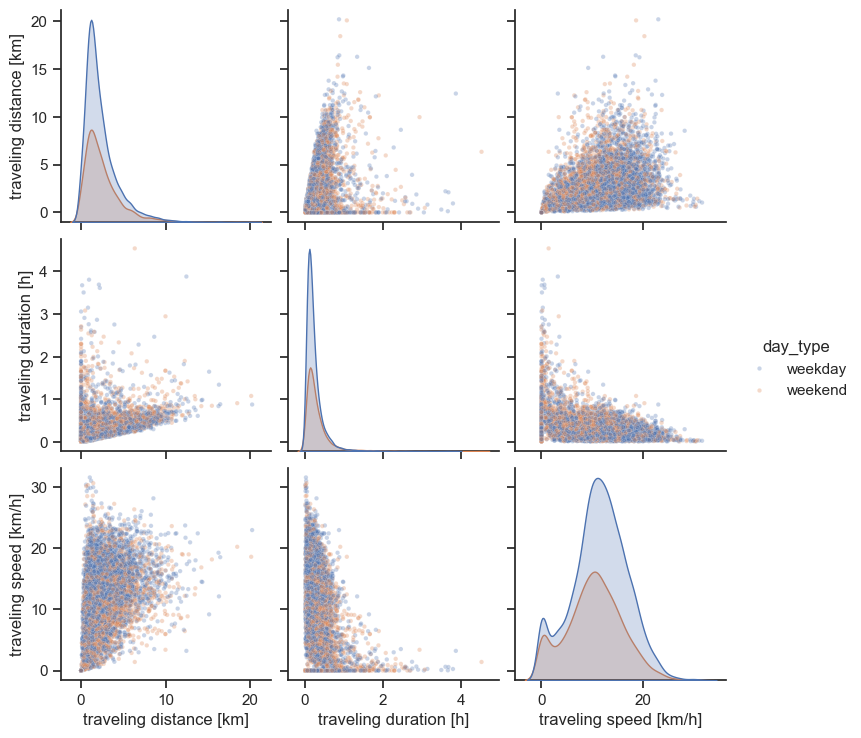

In [82]:
df_ = df[["rideable_type", "member_casual", "day_type",
          "traveling_distance", "traveling_duration", "traveling_speed"]]
df_["member_casual"] = df_["member_casual"].apply(lambda x: "non-member" if x == "casual" else x)
df_.columns = ["rideable_type", "member_casual", "day_type",
               "traveling distance [km]", "traveling duration [h]", "traveling speed [km/h]"]
sns.set_theme(style="ticks")
sns.pairplot(df_, plot_kws={"s": 10, "alpha": 0.3}, hue="day_type");

**Remarks**
* Not much noticeable difference between weekday and weekend. (the histrogram of weekday is higher because it's 5 days compared to 2 days of weekend.)

**Reasoning**
* We can probably see the difference in the number of rides at different hours w.r.t weekday and weekend. I assume that there is a riding pattern difference between them.

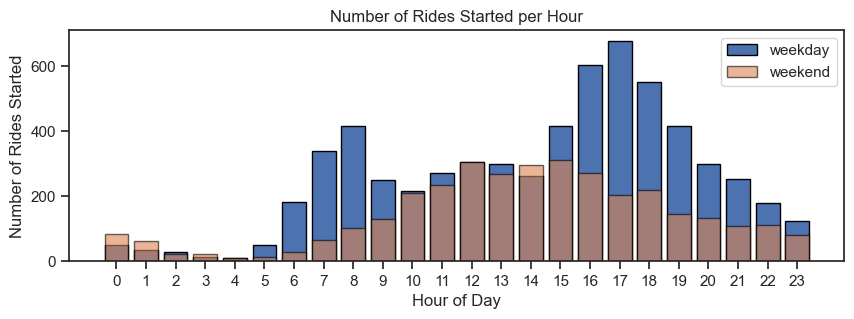

In [98]:
hour_counts_c1 = df[df["day_type"]=="weekday"]["started_at"].dt.hour.value_counts().sort_index()
hour_counts_c2 = df[df["day_type"]=="weekend"]["started_at"].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.bar(hour_counts_c1.index, hour_counts_c1.values, edgecolor="black", label="weekday")
plt.bar(hour_counts_c2.index, hour_counts_c2.values, edgecolor="black", label="weekend", alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides Started")
plt.title("Number of Rides Started per Hour")
plt.xticks(range(0,24))
plt.legend()
plt.show()

**Findings**
* During weekdays, there are clear peaks around commuting hours unlike weekend.

**Reasoning**
* This distributional pattern is quite similar to the one w.r.t membership. 
* Let's further dive into this by plotting "p(numer of rides | membership, day_type)"

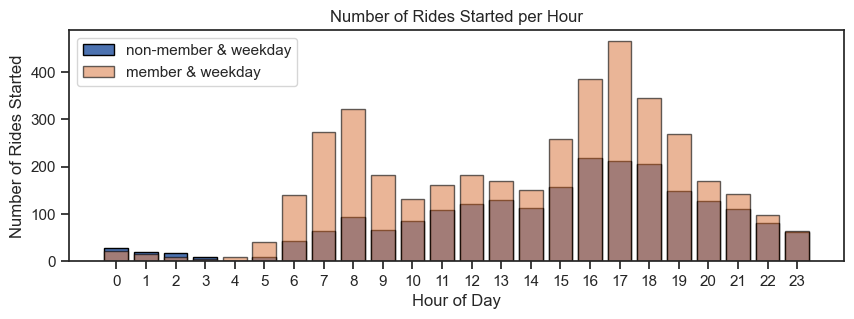

In [111]:
hour_counts_c1 = df[(df["member_casual"]=="casual") & (df["day_type"]=="weekday")]["started_at"].dt.hour.value_counts().sort_index()
hour_counts_c2 = df[(df["member_casual"]=="member") & (df["day_type"]=="weekday")]["started_at"].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.bar(hour_counts_c1.index, hour_counts_c1.values, edgecolor="black", label="non-member & weekday")
plt.bar(hour_counts_c2.index, hour_counts_c2.values, edgecolor="black", label="member & weekday", alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides Started")
plt.title("Number of Rides Started per Hour")
plt.xticks(range(0,24))
plt.legend()
plt.show()

**Remarks**
* Nothing surprising here.

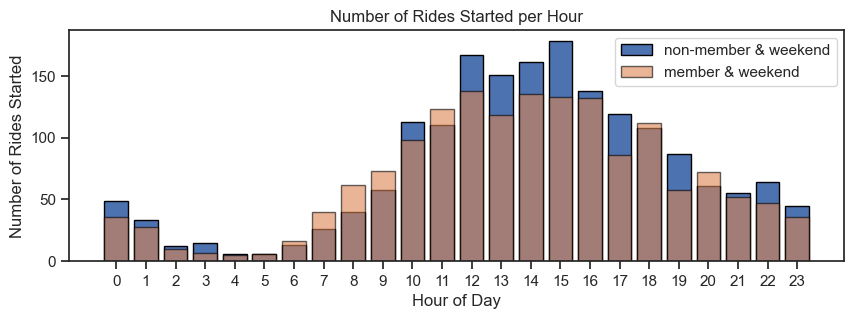

In [112]:
hour_counts_c1 = df[(df["member_casual"]=="casual") & (df["day_type"]=="weekend")]["started_at"].dt.hour.value_counts().sort_index()
hour_counts_c2 = df[(df["member_casual"]=="member") & (df["day_type"]=="weekend")]["started_at"].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.bar(hour_counts_c1.index, hour_counts_c1.values, edgecolor="black", label="non-member & weekend")
plt.bar(hour_counts_c2.index, hour_counts_c2.values, edgecolor="black", label="member & weekend", alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides Started")
plt.title("Number of Rides Started per Hour")
plt.xticks(range(0,24))
plt.legend()
plt.show()

**Remarks**
* New finding!
* On weekend, both members and non-members have similar riding patterns! while the patterns are different during weekdays due to commuting.

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

# Center map roughly on your data
center = [df["start_lat"].mean(), df["start_lng"].mean()]
min_lat, max_lat = df["start_lat"].min(), df["start_lat"].max()
min_lon, max_lon = df["start_lng"].min(), df["start_lng"].max()
m = folium.Map(location=center, 
            #    zoom_start=5, 
            #    tiles="OpenStreetMap",
               min_lat=min_lat,
               max_lat=max_lat,
               min_lon=min_lon,
               max_lon=max_lon,)

# 1) Marker clustering (good for many points)
cluster = MarkerCluster().add_to(m)

for _, r in df.iterrows():
    folium.Marker(
        location=[r["start_lat"], r["start_lng"]],
        popup=str(r.get("name", ""))  # optional column
    ).add_to(cluster)

m


In [10]:
df["member_casual"].unique()

array(['casual', 'member'], dtype=object)

In [14]:
df["ended_at"]

0     2025-12-21 15:00:51.179
1     2025-12-20 17:00:41.918
2     2025-12-27 13:06:19.710
3     2025-12-30 10:41:12.245
4     2025-12-20 13:48:11.772
                ...          
995   2025-12-10 14:48:40.095
996   2025-12-29 19:15:30.831
997   2025-12-10 17:39:52.037
998   2025-12-12 12:59:10.596
999   2025-12-04 10:14:03.701
Name: ended_at, Length: 1000, dtype: datetime64[ns]

In [15]:
df["started_at"]

0     2025-12-21 14:52:15.233
1     2025-12-20 16:52:08.830
2     2025-12-27 13:03:33.183
3     2025-12-30 10:37:28.191
4     2025-12-20 13:42:43.077
                ...          
995   2025-12-10 14:23:59.397
996   2025-12-29 19:12:12.268
997   2025-12-10 17:32:47.360
998   2025-12-12 12:35:18.603
999   2025-12-04 10:09:37.295
Name: started_at, Length: 1000, dtype: datetime64[ns]

In [17]:
df["ride_length"] = df["ended_at"] - df["started_at"]

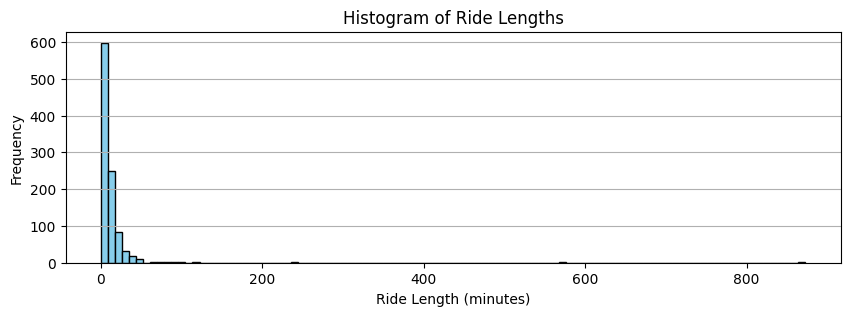

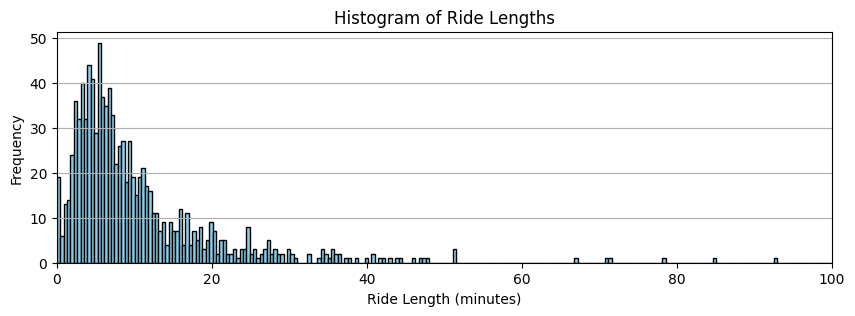

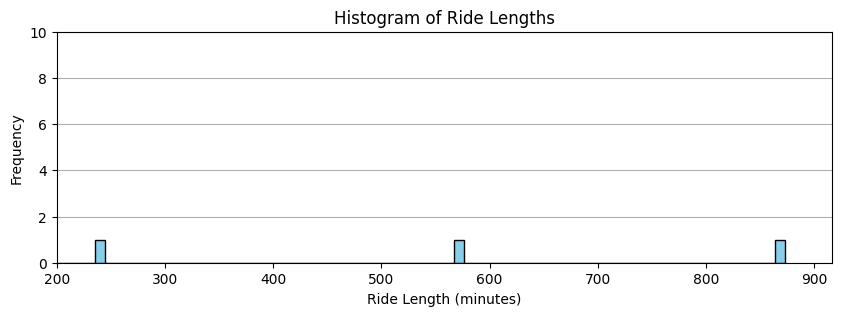

In [29]:
df["ride_length"]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.hist(df["ride_length"].dt.total_seconds() / 60, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Ride Length (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Ride Lengths")
plt.grid(axis='y')
plt.show()

#
plt.figure(figsize=(10, 3))
plt.hist(df["ride_length"].dt.total_seconds() / 60, bins=2000, color='skyblue', edgecolor='black')
plt.xlabel("Ride Length (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Ride Lengths")
plt.grid(axis='y')
plt.xlim(0, 100)
plt.show()

#
plt.figure(figsize=(10, 3))
plt.hist(df["ride_length"].dt.total_seconds() / 60, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Ride Length (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Ride Lengths")
plt.grid(axis='y')
plt.xlim(200, None)
plt.ylim(0, 10)
plt.show()

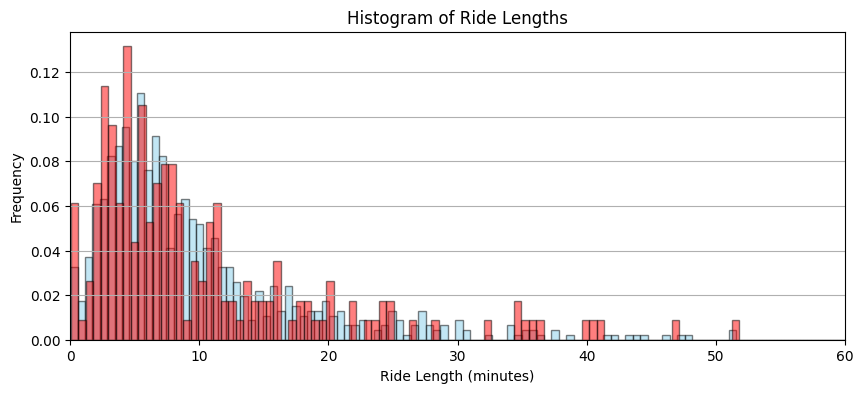

In [37]:
ride_length_member = df[df["member_casual"] == "member"]["ride_length"].dt.total_seconds()
ride_length_casual = df[df["member_casual"] == "casual"]["ride_length"].dt.total_seconds()

plt.figure(figsize=(10, 4))
plt.hist(ride_length_member / 60, bins=1000, color='skyblue', edgecolor='black', alpha=0.5, density=True)
plt.hist(ride_length_casual / 60, bins=1500, color='red', edgecolor='black', alpha=0.5, density=True)
plt.xlabel("Ride Length (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Ride Lengths")
plt.grid(axis='y')
plt.xlim(0, 60)
plt.show()

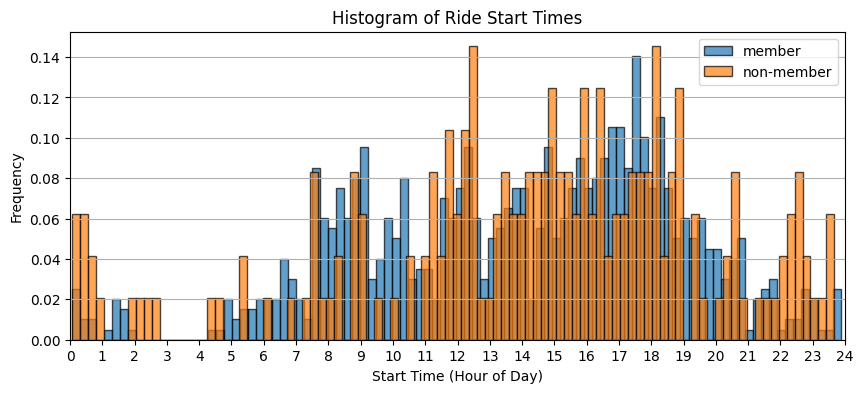

In [61]:

# Create a histogram of 'started_at' for 'member' users, using hour and minute

member_times = df[df["member_casual"] == "member"]["started_at"]
member_hours_minutes = member_times.dt.hour + member_times.dt.minute / 60

casual_times = df[df["member_casual"] == "casual"]["started_at"]
casual_hours_minutes = casual_times.dt.hour + casual_times.dt.minute / 60

plt.figure(figsize=(10, 4))
plt.hist(member_hours_minutes, bins=24*4, color='C0', edgecolor='black', alpha=0.7, density=True, label="member")
plt.hist(casual_hours_minutes, bins=24*4, color='C1', edgecolor='black', alpha=0.7, density=True, label="casual")
plt.xlabel("Start Time (Hour of Day)")
plt.ylabel("Frequency")
plt.title("Histogram of Ride Start Times")
plt.grid(axis='y')
plt.xticks(range(0,25))
plt.xlim(0,24)
plt.legend()
plt.show()


* `member`
    * high frequency around commuting hours and lunch hour
* `casual`
    * after 11 till 19 uniform; probably toursits
    * after 19, dinner hour, ppl are having dinner.
    * around 22-24, many traffic -> probably going home after dinner or drink
    * after 24(00): going home after drinks; higher density in `causal` than `member` because `causal` are probably toursits.

In [54]:
df[df["member_casual"] == "member"]["started_at"].dt.hour

1      16
3      10
4      13
5      13
6       9
       ..
994    16
995    14
996    19
997    17
999    10
Name: started_at, Length: 804, dtype: int32